This is a rough draft with brainstorming and ideas for the Medani quest.

House Medani is associated with the Mark of Detection, which allows them to sense hidden threats like poison and discover the intent behind others' words and actions. They are effectively counterintelligence experts or spycatchers -- they have a stronghold called the tower of interrogation where they extract secrets, and every trained Medani member is adept at telling whether someone is lying or telling the truth.

This feature will be exploited in the main quest for House Medani. Their lie detection powers come from elder script which can process audio and detect features which are indicative of lying or truthfulness. We will demo some simple signal processing tools to illustrate this, before using it to motivate studying the sounds of the invading abberations.

Source material includes https://github.com/calebmadrigal/FourierTalkOSCON, https://docs.scipy.org/doc/scipy-0.17.0/reference/tutorial/fftpack.html, and https://docs.scipy.org/doc/scipy-0.17.0/reference/tutorial/signal.html. Rough outline of curriculum:

(Intermediate: want to include spectrograms, audio recording, some noise filtering and transformations, and a learning problem of classification given different properties; ultimately need to justify understanding what the abberants are saying; todo is figure out how to record audio in notebook). Possible task: overlay several different screeches, slightly offset, and ask them to predict how many there are. Another possibly ask: give examples of ready and irritated, and ask them to program a rule to predict which is which [probably too hard]. TODO is brainstorm and insert more programming tasks).

* Tie-in with Medani lie detection and motivation of problem. Explanation of physical nature of sound waves (pressure/density fluctuations). Example of two different sounds (either two instruments, maybe two speech samples of a man and a woman). Lateral thinking activity: brainstorm as many characteristics of sound as you can (that is, properties that can be used to distinguish between two sounds). Good responses include pitch, volume, duration, inclusion of many different pitches, time variation of pitch and volume, etc.
* Intuitive explanation of Fourier transform and the frequency domain. Not sure if this should be motivated with the superposition principle. Maybe put the mathematical definition but this is intimidating. Demonstration for one of the given sounds. First coding task goes here -- probably something simple like obtaining the FFT and printing out the frequency with the highest spectral power density (literally run through a list keeping the largest element). Perhaps explain timbre comes from relative strengths of different frequency peaks.
* Plot interruption. Reveal the secret that House Medani wants to use its technology for analyzing audio to study the abberants. Perhaps this can be used to predict their behavior or, if they have a language, even to understand what they're saying!
* First audio sample of an abberrant (probably just a zergling waveform). Ask them to analyze with the tools they have. Possibly tell them about the spectrogram to see time dependence (better because it doesn't bucket together all of the modes).
* 

Ideas to include:
* spectrogram (mentioned above)
* recording their own audio sample; if we use the contrast between male and female voices, can also hand them a machine learning object and have it predict whether they have a male or female voice, although this is only impressive if highly accurate
* realtime (scope, scrolling spectrogram), perhaps via the interact() structure
* refining and adding more features, testing each of them to see whether they're different between their classes, coming up witha  rule
* one of the students has a special power which gives him knowledge of additional, specialized audio features to extract, like the ones listed here (http://recherche.ircam.fr/anasyn/peeters/ARTICLES/Peeters_2003_cuidadoaudiofeatures.pdf)
* need to think of integration with another team
* filtering example?

In [36]:
from scipy.io import wavfile
f = "../../audio/zergling_ready.wav"
rate, x = wavfile.read(f)

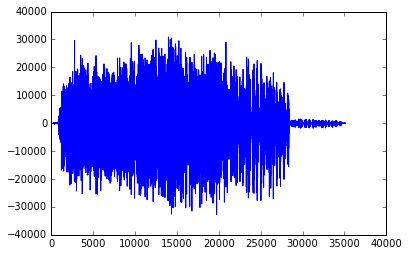

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(x)

In [22]:
import IPython
from IPython import display

IPython.display.Audio(x, rate=rate)

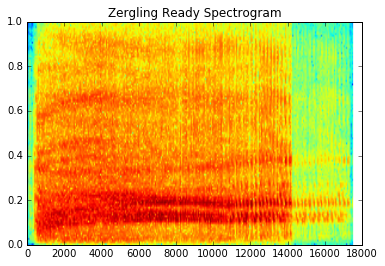

In [27]:
plt.specgram(x); plt.title("Zergling Ready Spectrogram")

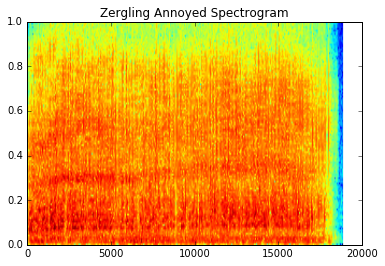

In [29]:
from scipy.io import wavfile
f2 = "../../audio/zergling_annoyed.wav"
rate2, x2 = wavfile.read(f2)

IPython.display.Audio(x2, rate=rate2)

plt.specgram(x2); plt.title("Zergling Annoyed Spectrogram")

In [32]:
"""
Stolen from stackoverflow
http://stackoverflow.com/questions/892199/detect-record-audio-in-python
"""
from sys import byteorder
from array import array
from struct import pack

import pyaudio
import wave

THRESHOLD = 500
CHUNK_SIZE = 1024
FORMAT = pyaudio.paInt16
RATE = 44100

def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

def normalize(snd_data):
    "Average the volume out"
    MAXIMUM = 16384
    times = float(MAXIMUM)/max(abs(i) for i in snd_data)

    r = array('h')
    for i in snd_data:
        r.append(int(i*times))
    return r

def trim(snd_data):
    "Trim the blank spots at the start and end"
    def _trim(snd_data):
        snd_started = False
        r = array('h')

        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)

            elif snd_started:
                r.append(i)
        return r

    # Trim to the left
    snd_data = _trim(snd_data)

    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

def add_silence(snd_data, seconds):
    "Add silence to the start and end of 'snd_data' of length 'seconds' (float)"
    r = array('h', [0 for i in xrange(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in xrange(int(seconds*RATE))])
    return r

def record():
    """
    Record a word or words from the microphone and 
    return the data as an array of signed shorts.

    Normalizes the audio, trims silence from the 
    start and end, and pads with 0.5 seconds of 
    blank sound to make sure VLC et al can play 
    it without getting chopped off.
    """
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False

    r = array('h')

    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)

        silent = is_silent(snd_data)

        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True

        if snd_started and num_silent > 30:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()

    r = normalize(r)
    r = trim(r)
    r = add_silence(r, 0.5)
    return sample_width, r

def record_to_file(path):
    "Records from the microphone and outputs the resulting data to 'path'"
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()
    
sample, r = record()

In [35]:
IPython.display.Audio(r, rate=44100)